# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [ ]:
%load_ext dotenv
%dotenv 
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.impute import SimpleImputer


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [229]:
# Separate the target variable ('area') from the features
X = fires_dt.drop(columns=['area'])  # Drop the target column to create features
Y = fires_dt['area']                 # Set the target variable
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,X.shape, Y.shape, Y_train.shape )

(413, 12) (517, 12) (517,) (413,)


In [26]:
if type(fires_dt) == pd.DataFrame:
    print("fires_dt is a DataFrame")
else:
    print("fires_dt is not a DataFrame")

fires_dt is a DataFrame


In [ ]:
print("Features (X):")
print(X.head())
print("\narea (Y):")
print(Y.head())

Features (X):
   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0

area (Y):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

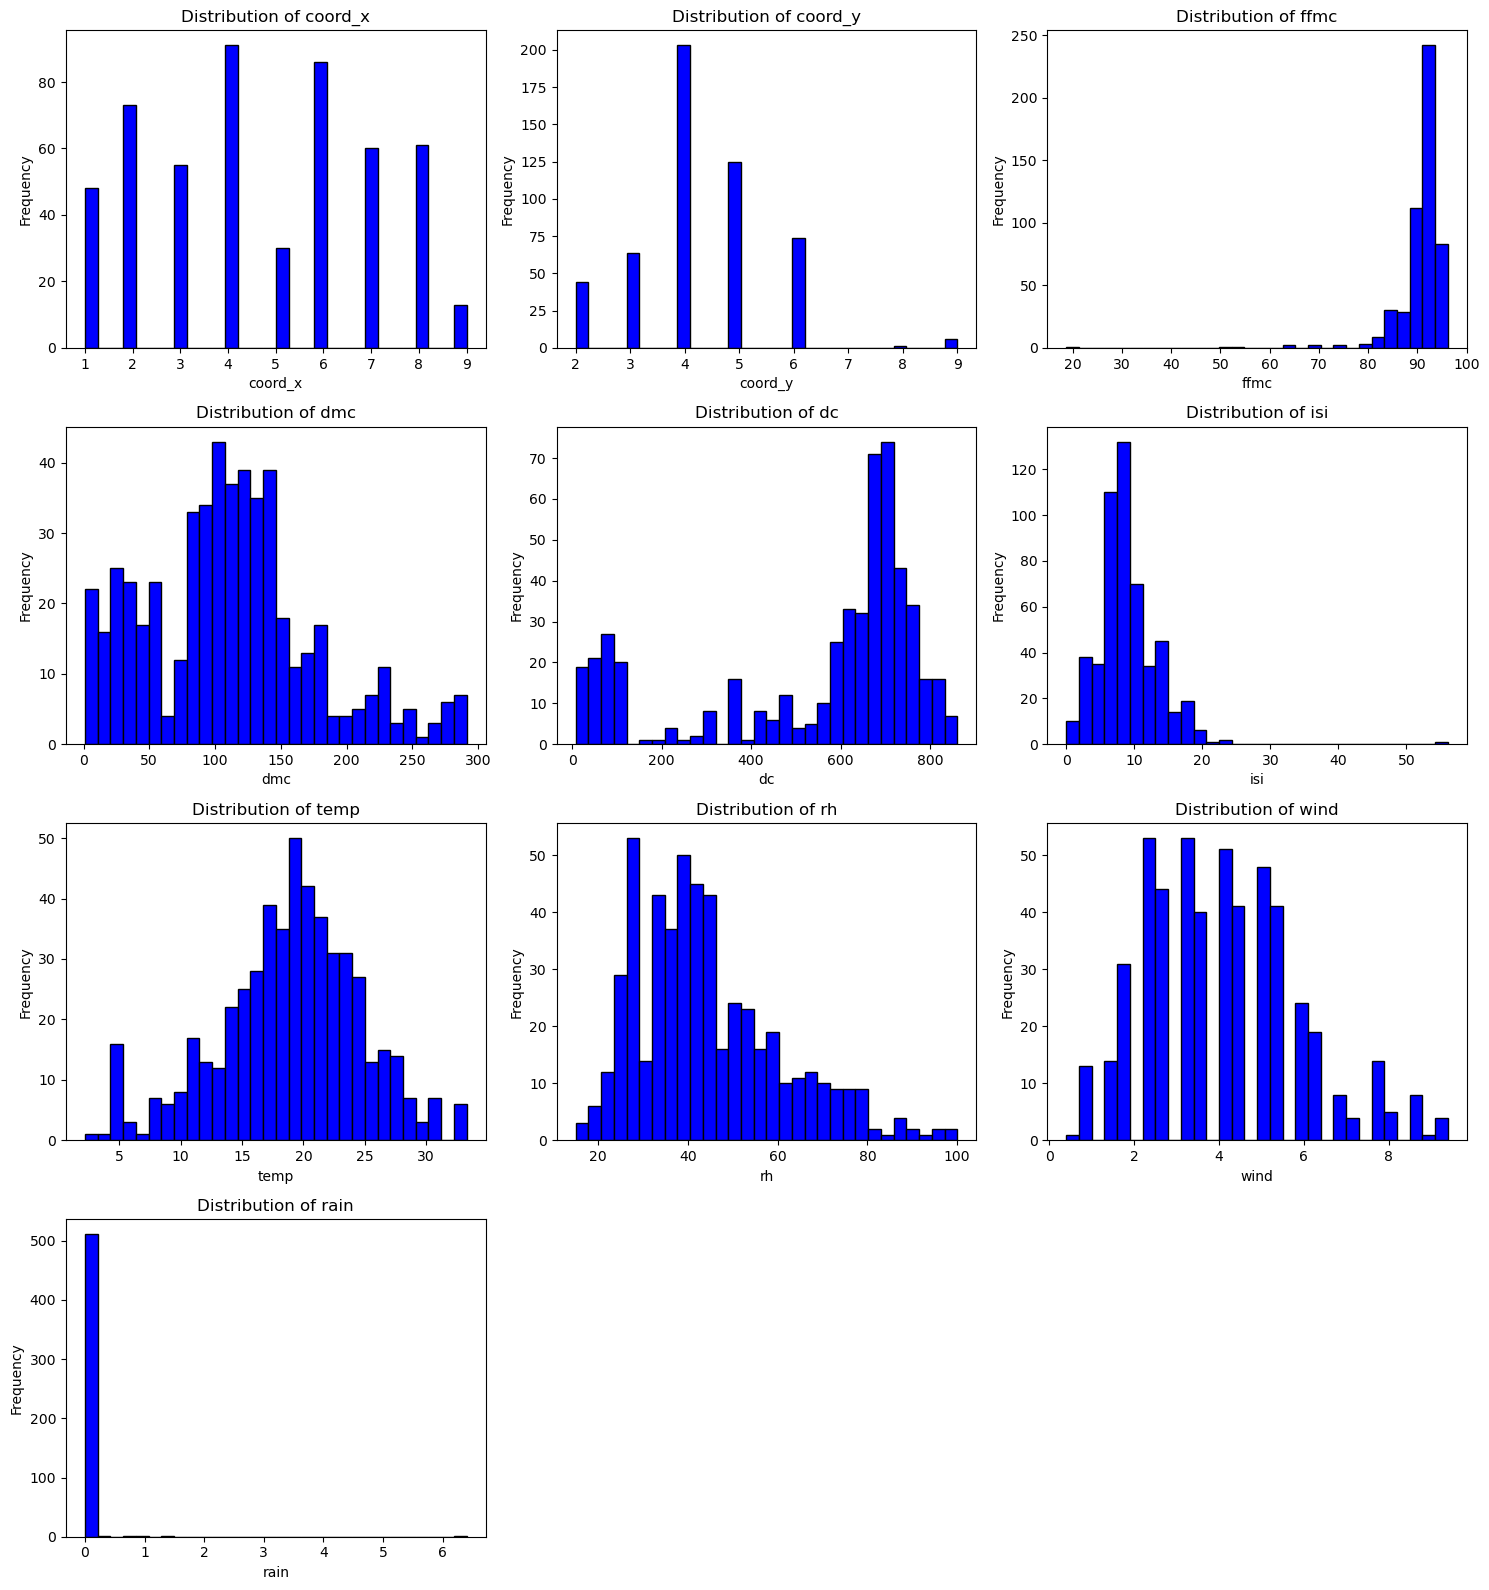

In [117]:
import matplotlib.pyplot as plt
import math
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind','rain']

n_features = len(numeric_features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

for i, feature in enumerate(numeric_features):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    ax.hist(fires_dt[feature], bins=30, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Turn off any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


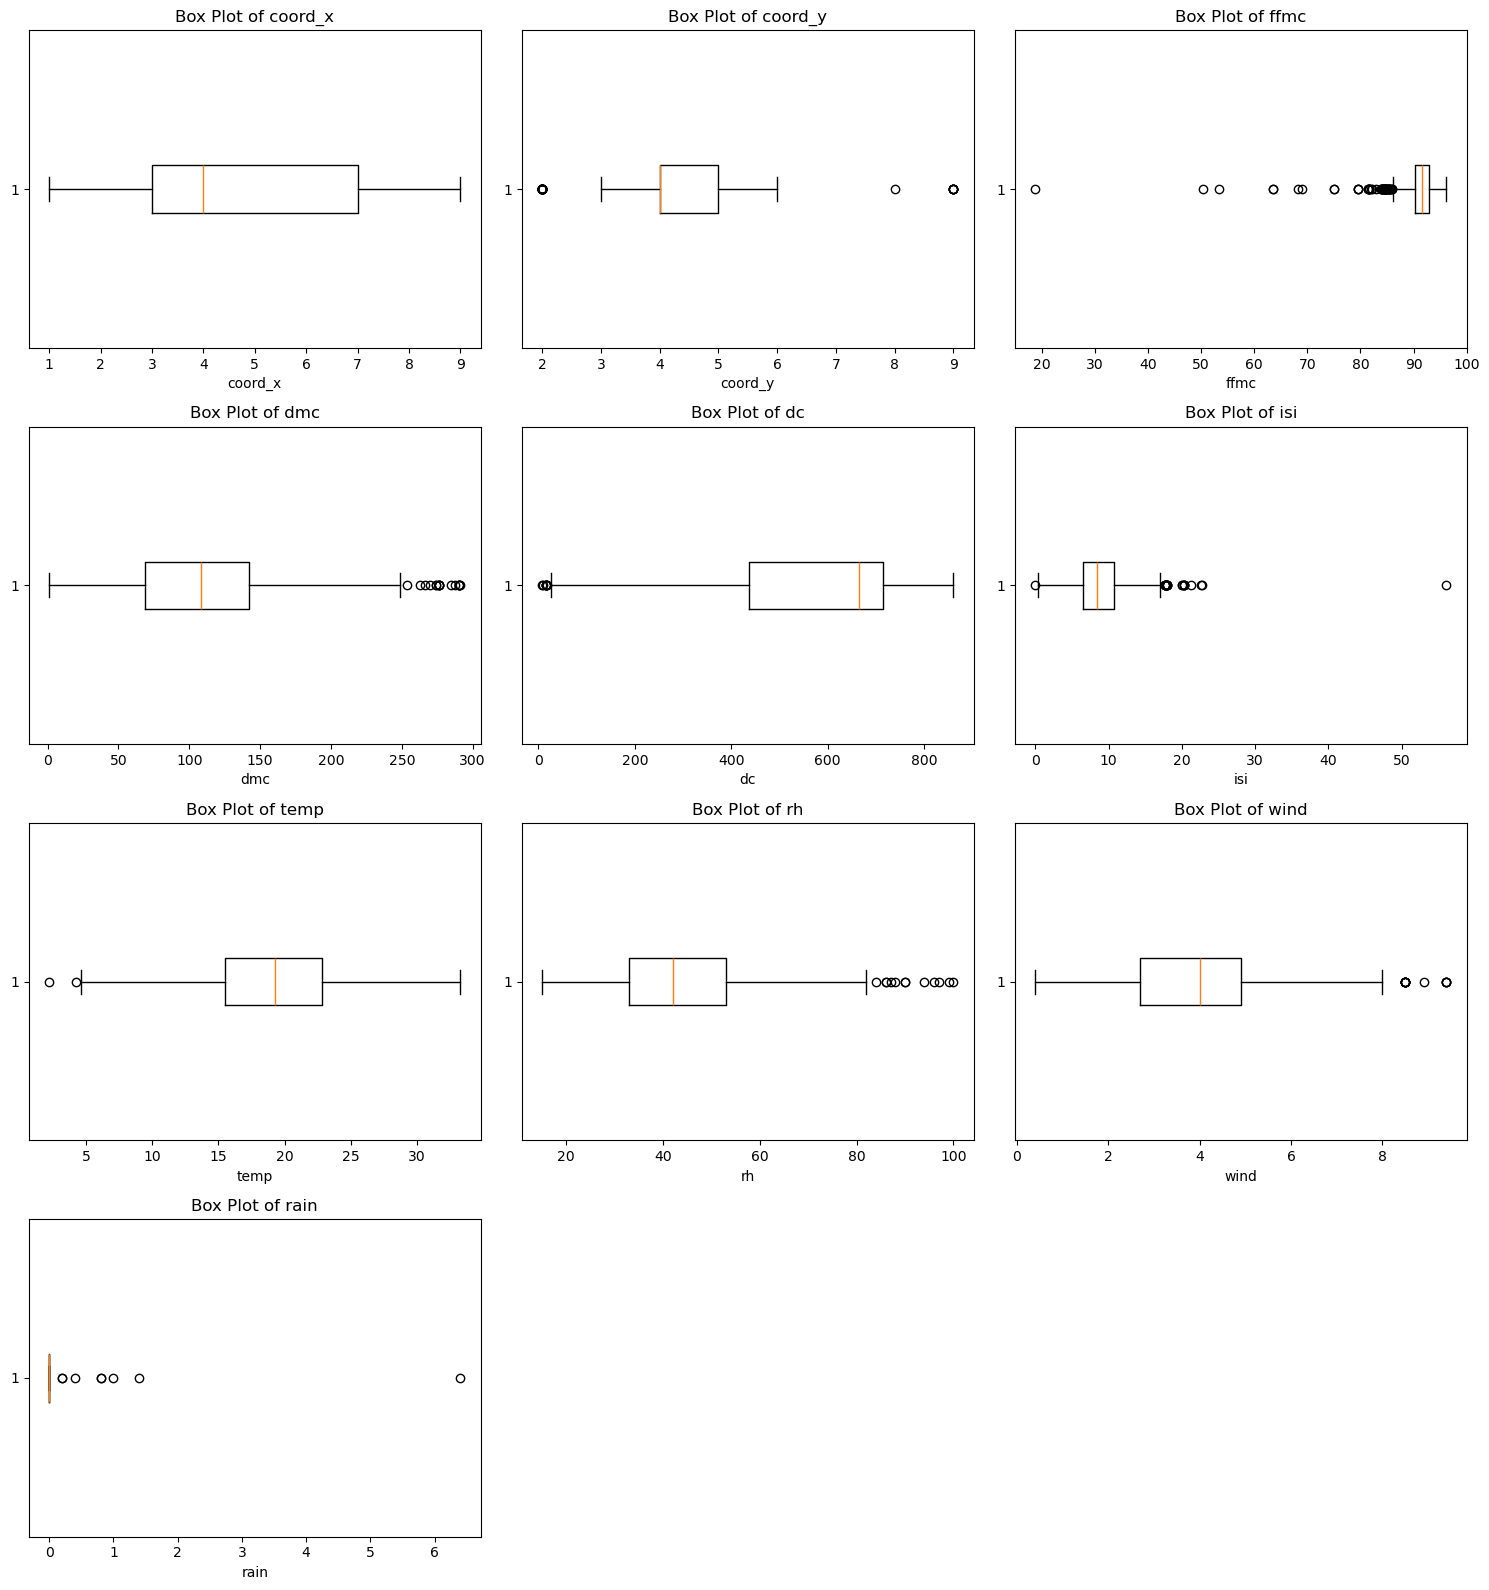

In [118]:
# Define grid layout based on the number of numeric features
n_features = len(numeric_features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), squeeze=False)

for i, feature in enumerate(numeric_features):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    ax.boxplot(fires_dt[feature].dropna(), vert=False)
    ax.set_title(f'Box Plot of {feature}')
    ax.set_xlabel(feature)

# Turn off any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [259]:
# Define the columns by their data types
numeric_features = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind']  # Add other numeric columns if needed
categorical_features = ['month', 'day']  # Add other categorical columns if needed

# Define the preprocessing steps
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),          # Scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)        # One-hot encode categorical features
    ]
)

# Display the preproc1 configuration
print(preproc1)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [260]:
# Define non-linear transformation (log) for one of the numeric features
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Using log1p to handle zero values

# Define the preprocessing steps
preproc2 = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind']),  # Standard scaling
        ('num_log', Pipeline([('log', log_transformer), ('scale', StandardScaler())]), ['ffmc', 'dmc', 'dc', 'isi', 'rh', 'wind']),         # Log transform and scale
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['month', 'day'])                                                       # One-hot encode categorical
    ]
)

# Display the preproc2 configuration
print(preproc2)

ColumnTransformer(transformers=[('num_scaled', StandardScaler(),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind']),
                                ('num_log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('scale', StandardScaler())]),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'rh', 'wind']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [239]:
# Define the baseline and advanced regression models
baseline_model = LinearRegression()
advanced1_model = RandomForestRegressor()
advanced2_model_gb = GradientBoostingRegressor()


In [261]:
X1 = fires_dt.drop(columns=['area','coord_x', 'coord_y','rain'])  # Drop the target column to create features
Y1 = fires_dt['area']                 # Set the target variable

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
print(X1_train.shape,X1.shape, Y1.shape, Y1_train.shape )

scorings = ['neg_log_loss', 'roc_auc', 'f1', 'accuracy', 'precision', 'recall']

(413, 9) (517, 9) (517,) (413,)


In [262]:
# Create Pipeline A using preproc1 and baseline model
pipeline_A1 = Pipeline([
    ('preprocessing', preproc1),          # Use preproc1
    ('regressor', baseline_model)         # Baseline model (e.g., Linear Regression)
])
print(X1_train.shape)

# Now you can use this DataFrame in your pipeline
pipeline_A1.fit(X1_train, Y1_train)


(413, 9)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [263]:
scoring_A1 = ['neg_mean_squared_error', 'r2']
res_simple_dict_A1 = cross_validate(pipeline_A1, X1_train, Y1_train, cv = 5, scoring = scoring_A1)
res_simple_A1 = pd.DataFrame(res_simple_dict_A1).assign(experiment = 1)
res_simple_A1

,fit_time,score_time,test_neg_mean_squared_error,test_r2,experiment
0,0.011575,0.009694,-1677.558820,-0.028349,1
1,0.009031,0.005001,-383.397534,-0.772268,1
2,0.012171,0.006056,-835.634485,-0.160077,1
3,0.007482,0.003053,-7338.207788,-0.018518,1
4,0.005000,0.003876,-745.064328,-0.269046,1


In [264]:
# Create Pipeline A using preproc2 and baseline model
pipeline_A2 = Pipeline([
    ('preprocessing', preproc2),          # Use preproc2
    ('regressor', baseline_model)         # Baseline model (e.g., Linear Regression)
])
pipeline_A2.fit(X1_train, Y1_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind']),
                                                 ('num_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'rh', 'wind']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [265]:
scoring_A2 = ['neg_mean_squared_error', 'r2']
res_simple_dict_A2 = cross_validate(pipeline_A2, X1_train, Y1_train, cv = 5, scoring = scoring_A2)
res_simple_A2 = pd.DataFrame(res_simple_dict_A2).assign(experiment = 1)
res_simple_A2

,fit_time,score_time,test_neg_mean_squared_error,test_r2,experiment
0,0.018523,0.007874,-1667.200489,-0.022000,1
1,0.009740,0.009926,-379.530631,-0.754393,1
2,0.014937,0.005378,-826.627829,-0.147574,1
3,0.007505,0.003992,-7659.255351,-0.063079,1
4,0.008081,0.003000,-759.898835,-0.294314,1


In [266]:

# Create Pipeline B using preproc1 and advanced model
pipeline_B1 = Pipeline([
    ('preprocessing', preproc1),          # Use preproc1
    ('regressor', advanced1_model)         # Advanced model (e.g., Random Forest)
])
pipeline_B1.fit(X1_train, Y1_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [267]:
scoring_B1 = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
res_simple_dict_B1 = cross_validate(pipeline_B1, X1_train, Y1_train, cv=5, scoring=scoring_B1)
res_simple_B1 = pd.DataFrame(res_simple_dict_B1).assign(experiment=1)
res_simple_B1

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,experiment
0,0.220037,0.008373,-21.034655,-57.882224,-1.053777,1
1,0.207400,0.007684,-23.655245,-43.837128,-7.883093,1
2,0.211777,0.007713,-16.017796,-29.889322,-0.240231,1
3,0.207264,0.012009,-25.893029,-87.167263,-0.054595,1
4,0.222174,0.008605,-13.065339,-27.488370,-0.287009,1


In [268]:

# Create Pipeline B using preproc2 and advanced model
pipeline_B2 = Pipeline([
    ('preprocessing', preproc2),          # Use preproc2
    ('regressor', advanced1_model)         # Advanced model (e.g., Random Forest)
])
pipeline_B2.fit(X1_train, Y1_train)   

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind']),
                                                 ('num_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'rh', 'wind']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [269]:
scoring_B2 = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
res_simple_dict_B2 = cross_validate(pipeline_B2, X1_train, Y1_train, cv=5, scoring=scoring_B2)
res_simple_B2 = pd.DataFrame(res_simple_dict_B2).assign(experiment=1)
res_simple_B2

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,experiment
0,0.324030,0.010391,-20.800152,-59.491751,-1.169584,1
1,0.335394,0.009306,-23.182009,-46.433684,-8.966583,1
2,0.313652,0.010376,-15.963520,-29.999520,-0.249393,1
3,0.320007,0.013122,-24.778327,-86.910366,-0.048388,1
4,0.289804,0.009103,-13.186343,-28.422853,-0.376002,1


In [270]:
# Create Pipeline C using preproc1 and advanced model
pipeline_C1 = Pipeline([
    ('preprocessing', preproc1),          # Use preproc1
    ('regressor', advanced2_model_gb)         # Advanced model (e.g., Gradient Boosting)
])
pipeline_C1.fit(X1_train, Y1_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', GradientBoostingRegressor())])

In [271]:
scoring_C1 = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
res_simple_dict_C1 = cross_validate(pipeline_C1, X1_train, Y1_train, cv=5, scoring=scoring_C1)
res_simple_C1 = pd.DataFrame(res_simple_dict_C1).assign(experiment=1)
res_simple_C1

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,experiment
0,0.095394,0.004102,-23.428184,-76.967905,-2.631468,1
1,0.088113,0.006783,-29.300678,-83.672693,-31.362905,1
2,0.088410,0.004744,-15.822862,-32.136299,-0.433713,1
3,0.089746,0.004328,-25.374952,-87.925647,-0.073025,1
4,0.089774,0.002998,-11.890313,-27.252463,-0.265014,1


In [272]:
# Create Pipeline C using preproc2 and advanced model
pipeline_C2 = Pipeline([
    ('preprocessing', preproc2),          # Use preproc2
    ('regressor', advanced2_model_gb)         # Advanced model (e.g., Gradient Boosting)
])
pipeline_C2.fit(X1_train, Y1_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaled',
                                                  StandardScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind']),
                                                 ('num_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'rh', 'wind']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', GradientBoostingRegressor())])

In [273]:
scoring_C2 = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
res_simple_dict_C2 = cross_validate(pipeline_C2, X1_train, Y1_train, cv=5, scoring=scoring_C2)
res_simple_C2 = pd.DataFrame(res_simple_dict_C2).assign(experiment=1)
res_simple_C2

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,experiment
0,0.135314,0.005026,-24.389785,-84.938443,-3.422537,1
1,0.108554,0.004926,-28.050035,-76.906243,-26.340295,1
2,0.106407,0.013370,-15.906685,-32.167442,-0.436493,1
3,0.129925,0.005606,-24.996147,-87.840610,-0.070951,1
4,0.116053,0.006039,-13.918394,-36.020639,-1.209971,1


In [274]:
# remove or impute missing values if necessary
imputer = SimpleImputer(strategy='mean')  # Use mean imputation

# Define preprocessing for numeric and categorical features
preproc3 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer), ('scaler', StandardScaler())]), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)
preproc3


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind']),
                                ('cat', OneHotEncoder(), ['month', 'day'])])

In [275]:
# Create Pipeline A using preproc2 and baseline model
pipeline_A3 = Pipeline([
    ('preprocessing', preproc3),          # Use preproc2
    ('regressor', baseline_model)         # Baseline model (e.g., Linear Regression)
])
pipeline_A3.fit(X1_train, Y1_train)

scoring_A3 = ['neg_mean_squared_error', 'r2']
res_simple_dict_A3 = cross_validate(pipeline_A3, X1_train, Y1_train, cv = 5, scoring = scoring_A3)
res_simple_A3 = pd.DataFrame(res_simple_dict_A3).assign(experiment = 1)
res_simple_A3

c:\Users\user\.conda\envs\scale2prod\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\user\.conda\envs\scale2prod\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\user\.conda\envs\scale2prod\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\user\.conda\envs\scale2prod\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\.conda\envs\scale2prod\Lib\site-packages\sklearn\utils\_response.py", line 239, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
                        ^^^^^^^^^^^^^^^^

,fit_time,score_time,test_neg_mean_squared_error,test_r2,experiment
0,0.009462,0.003114,-1677.558820,-0.028349,1
1,0.015126,0.004865,-383.397534,-0.772268,1
2,0.009052,0.003000,-835.634485,-0.160077,1
3,0.005211,0.005726,NaN,NaN,1
4,0.007101,0.005999,NaN,NaN,1


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [276]:
# Hyperparameters for Linear Regression 
param_grid_A = {
    'regressor__fit_intercept': [True, False],
    #'regressor__normalize': [True, False]
}


In [277]:
# Perform GridSearch for Linear Regression with preproc1
grid_search_A1 = GridSearchCV(pipeline_A1, param_grid_A, cv=5, scoring='r2', n_jobs=-1)
grid_search_A1.fit(X1_train, Y1_train)
print("Best parameters for Linear Regression:", grid_search_A1.best_params_)
print("Best score for Linear Regression:", grid_search_A1.best_score_)

Best parameters for Linear Regression: {'regressor__fit_intercept': False}
Best score for Linear Regression: -0.24931499568072835


In [278]:
# Perform GridSearch for Linear Regression with preproc2
grid_search_A2 = GridSearchCV(pipeline_A2, param_grid_A, cv=5, scoring='r2', n_jobs=-1)
grid_search_A2.fit(X1_train, Y1_train)
print("Best parameters for Linear Regression:", grid_search_A2.best_params_)
print("Best score for Linear Regression:", grid_search_A2.best_score_)

Best parameters for Linear Regression: {'regressor__fit_intercept': False}
Best score for Linear Regression: -0.2557690916837455


In [281]:
# Hyperparameters for Random Forest
param_grid_B = {
    'regressor__n_estimators': np.arange(50, 301, 50),
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False],
    'regressor__max_features': ['sqrt', 'log2', None]  # Correcting the invalid option
}

In [283]:
# Perform GridSearch for Random Forest with preproc1
grid_search_B1 = GridSearchCV(pipeline_B1, param_grid_B, cv=5, scoring='r2', n_jobs=-1)
grid_search_B1.fit(X1_train, Y1_train)
print("Best parameters for Random Forest:", grid_search_B1.best_params_)
print("Best score for Random Forest:", grid_search_B1.best_score_)

Best parameters for Random Forest: {'regressor__bootstrap': True, 'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 50}
Best score for Random Forest: -0.23129729647372604


In [287]:

# Perform GridSearch for Random Forest with preproc2
grid_search_B2 = GridSearchCV(pipeline_B2, param_grid_B, cv=5, scoring='r2', n_jobs=-1)
grid_search_B2.fit(X1_train, Y1_train)
print("Best parameters for Random Forest:", grid_search_B2.best_params_)
print("Best score for Random Forest:", grid_search_B2.best_score_)


Best parameters for Random Forest: {'regressor__bootstrap': True, 'regressor__max_depth': 30, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best score for Random Forest: -0.29350346119094084


c:\Users\user\.conda\envs\scale2prod\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [247]:
# Hyperparameters for Gradient Boosting
param_grid_C = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0]
}

In [ ]:
# Perform GridSearch for Gradient Boosting with preproc1
grid_search_C1 = GridSearchCV(pipeline_C1, param_grid_C, cv=5, scoring='r2', n_jobs=-1)
grid_search_C1.fit(X1_train, Y1_train)
print("Best parameters for Gradient Boosting:", grid_search_C1.best_params_)
print("Best score for Gradient Boosting:", grid_search_C1.best_score_)

Best parameters for Gradient Boosting: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 50, 'regressor__subsample': 0.8}
Best score for Gradient Boosting: -0.7184028109005423


In [249]:
# Perform GridSearch for Gradient Boosting with preproc2
grid_search_C2 = GridSearchCV(pipeline_C2, param_grid_C, cv=5, scoring='r2', n_jobs=-1)
grid_search_C2.fit(X1_train, Y1_train)
print("Best parameters for Gradient Boosting:", grid_search_C2.best_params_)
print("Best score for Gradient Boosting:", grid_search_C2.best_score_)

Best parameters for Gradient Boosting: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 0.8}
Best score for Gradient Boosting: -0.6088144599787171


# Evaluate

+ Which model has the best performance?

The best score you received for the Random Forest model is negative, specifically -0.229, which indicates that the model is performing worse than the simple baseline (predicting the mean value for all data points).
This negative R-squared score, combined with the failure warnings, suggests that the model is not well-suited to the data, and there could be problems with the data itself, the model's hyperparameters, or both.

The error message indicates that the max_features parameter was set to "auto", which is not valid. The RandomForestRegressor accepts only certain values for max_features:
1) int: The number of features to consider at each split (e.g., an integer number).
2) float: The fraction of features to consider (e.g., 0.8 means using 80% of the features).
{'sqrt', 'log2'}: A predefined strategy that selects a subset of features based on the square root or log2 of the total number of features.
3) None: Uses all features (which is the default).
This issue might have arisen because "auto" is not a valid option for max_features. You can fix this by explicitly setting max_features to "sqrt" or another valid option.

How to Fix:
1) Addressing the Invalid max_features Parameter:
Change your hyperparameter grid to ensure that max_features has valid values. Modify the hyperparameter search space for max_features in the param_dist.
2) Improving Model Performance:
Feature Engineering: Review your features to ensure they are relevant. Sometimes, irrelevant features or noisy data can cause models to underperform.
Try Simpler Models: As a baseline, try fitting a simpler model, such as linear regression, and check if the performance improves.
Cross-Validation: Make sure you're using proper cross-validation. If your dataset is small or unbalanced, increasing the number of folds might help improve generalization.
Address Missing Values: Ensure there are no missing values in your features and that any categorical features are properly encoded.
3) Further Debugging:
Train/Test Split: Ensure that the data used for training and testing is properly split, and that there is no data leakage between the training and test sets.
GridSearch Results: Investigate the hyperparameter grid search results carefully. You might need to expand the range of hyperparameters (e.g., n_estimators or max_depth) and ensure that you are fitting on a diverse set of parameters.



# Export

+ Save the best performing model to a pickle file.

In [ ]:
import pickle

# Specify the path and name for the pickle file
filename = 'best_model.pkl'

# Save the model to the pickle file
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"The best model has been saved to {filename}.")
best_model = grid_search.best_estimator_

In [ ]:
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)
print(f"Loaded model: {loaded_model}")

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [ ]:
import shap

# Initialize SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_train)

# Select an observation from the test set
observation = X_test.iloc[0]  # Change the index as needed

# Compute SHAP values for the selected observation
shap_values = explainer(observation)

# Plot the SHAP values for the observation
shap.plots.waterfall(shap_values[0])

In [ ]:
# Compute SHAP values for the entire training set
shap_values_train = explainer(X_train)

# Summarize feature importance
shap.summary_plot(shap_values_train, X_train)

In [ ]:
# Drop least important features
least_important_features = ['feature_name_1', 'feature_name_2']  # Replace with actual feature names
X_train_reduced = X_train.drop(columns=least_important_features)
X_test_reduced = X_test.drop(columns=least_important_features)

# Retrain the model
best_model_reduced = best_model.fit(X_train_reduced, y_train)

# Evaluate the new model
from sklearn.metrics import mean_squared_error, r2_score

y_pred_reduced = best_model_reduced.predict(X_test_reduced)
print("R²:", r2_score(y_test, y_pred_reduced))
print("RMSE:", mean_squared_error(y_test, y_pred_reduced, squared=False))

Deciding Which Features to Remove
Remove Features If:

They are among the least important according to SHAP values.
They are highly correlated with other features (redundant information).
They introduce noise or complexity without improving predictive performance.
Validation:

Use cross-validation to confirm that the reduced feature set does not harm model performance.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.